<a href="https://colab.research.google.com/github/CYBERIC-EA/JAMES-S-YOUTUBE-CHANNEL-ANALYSIS/blob/main/jay_scholz_channels_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction:

In today's digital age, YouTube has emerged as a powerful platform for knowledge sharing, entertainment, and community building. Among the vast array of content creators, one channel that i really like is : Jay Scholz's YouTube channel. Through this analysis, we aim to provide Jay Scholz with valuable insights into the performance, engagement, and audience preferences of his channels.

In [ ]:
!pip install isodate
# from wordcloud import WordCloud
from time import strftime
from IPython.display import JSON
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
from dateutil import parser
from wordcloud import WordCloud
# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import isodate
import seaborn as sns


sns.set(style="darkgrid", color_codes=True)

# Google API


# NLP libraries
nltk.download('stopwords')
nltk.download('punkt')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

retrieve api key

In [ ]:
api_key = #your api key
api_service_name = "youtube"
api_version = "v3"

channel_ids = [
               #jay skullz
               "UCYCO3Kifwg56zhus3XXiAVg",
               #james scholz
               "UCMwo6hT5hI3R56rO2HYP-wQ",
               #j.v. scholz
               "UCcaTUtGzOiS4cqrgtcsHYWg"
               # you can add more channed ids here
               ]
               
# create an api client
youtube = build(api_service_name, api_version, developerKey=api_key)


In [ ]:
def get_channel_stats(youtube, channel_ids):
    request = youtube.channels().list(part="snippet,contentDetails,statistics",
                                      id=",".join(channel_ids))

    
    response = request.execute()


    all_data = []
    for item in response['items']:
        data = {'channelName': item['snippet']['title'], 'subscribers': item['statistics']['subscriberCount'], 'views': item['statistics']
                ['viewCount'], 'totalVideos': item['statistics']['videoCount'], 'playlistId': item['contentDetails']['relatedPlaylists']['uploads'], }
        all_data.append(data)
    return(pd.DataFrame(all_data))



In [ ]:
channel_stats = get_channel_stats(youtube, channel_ids)
print(channel_stats)

    channelName subscribers     views totalVideos                playlistId
0      jvscholz      175000   9150926          26  UUcaTUtGzOiS4cqrgtcsHYWg
1    jay skullz      213000  10384209          85  UUYCO3Kifwg56zhus3XXiAVg
2  James Scholz      738000  44027632         406  UUMwo6hT5hI3R56rO2HYP-wQ


AFTER GETTING THE STATS FOR THE CHANNELS, WE WANT THE STATS FOR EACH PLAYLIST IN THE CHANNEL


In [ ]:
playlist_Id = "UUMwo6hT5hI3R56rO2HYP-wQ"


In [ ]:
def get_video_ids(youtube, playlist_Id):
    video_ids = []
    request = youtube.playlistItems().list(part="snippet,ContentDetails",
                                           playlistId="UU2jxJHf569ZcA6LHajBZ7rg", maxResults=50)
    # by default you can only retrieve 5 video ids but i can change it by doing:
    # first increase the total number of results(maxResults) from 5 videos to 50
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    # set up a way to go to the next page to continue retrieving videos
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="ContentDetails",
            playlistId=playlist_Id,
            # by default you can only retrieve 5 video ids but i can change it by doing:
            # first increase the total number of results from 5 videos to 50
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        next_page_token = response.get('nextPageToken')

    return video_ids


In [ ]:
video_ids = get_video_ids(youtube, playlist_Id)

In [ ]:
def get_video_details(youtube, video_ids):
    
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                             }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)



In [ ]:
video_df = get_video_details(youtube, video_ids)

AFTER RETRIEVING ALL THE RESOURCES WE NEED, WE NEED TO NORMALIZE THE DATA WE'VE GOTTEN IN ORDER TO UTILIZE THEM FOR THE ANALYSIS OF OUR CHOICE


In [ ]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)


# Create publish day (in the week) column
video_df['publishedAt'] = video_df['publishedAt'].apply(
    lambda x: parser.parse(x))
video_df['publishDayName'] = video_df['publishedAt'].apply(
    lambda x: x.strftime("%A"))

# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(
    lambda x: 0 if x is None else len(x))

# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data = get_channel_stats(youtube, channel_ids)

channel_data[numeric_cols] = channel_data[numeric_cols].apply(
    pd.to_numeric, errors='coerce')





# 1. SUBSCRIBERS PER CHANNEL
We can compare the suscribers of different channels by updating the channel id list.

Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.


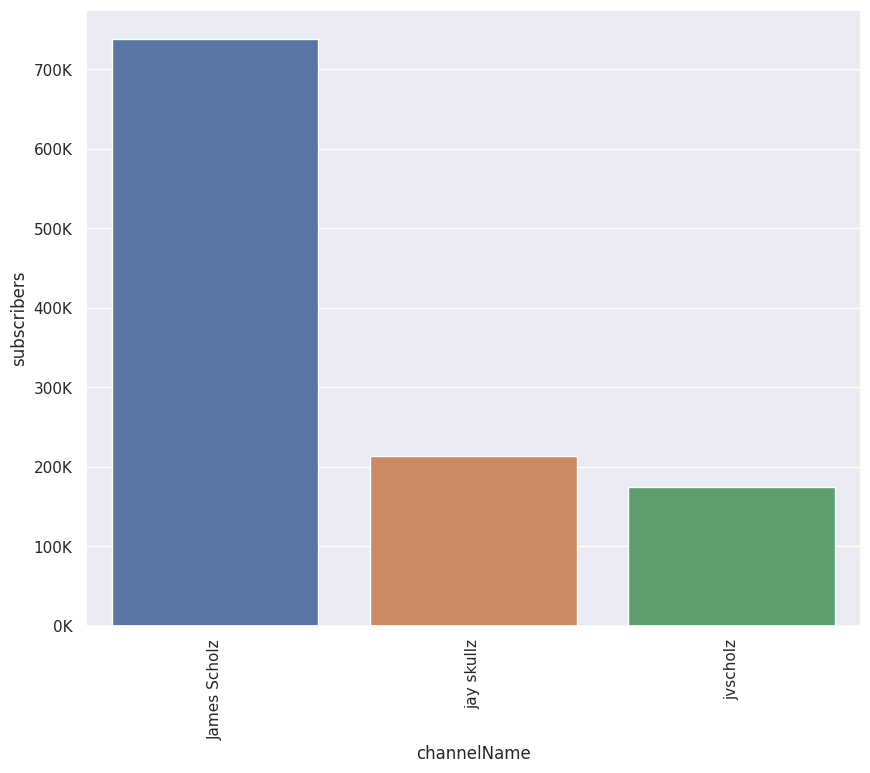

In [ ]:
sns.set(rc={'figure.figsize': (10, 8)})
ax = sns.barplot(x='channelName', y='subscribers',
                 data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# 2. VIDEOS PER CHANNEL
We can compare the total number of uploaded videos of different channels by updating the channel id list.

Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.


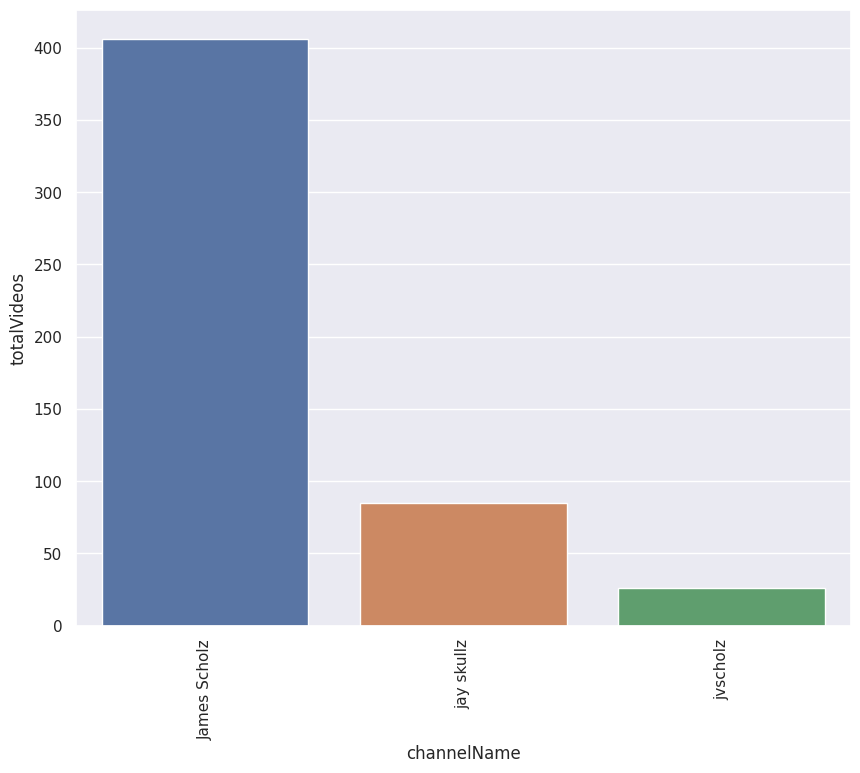

In [ ]:
sns.set(rc={'figure.figsize': (10, 8)})
ax = sns.barplot(x='channelName', y='totalVideos',
                 data=channel_data.sort_values('totalVideos', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: '{:,.0f}'.format(x)))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Based on the the two visualizations above you can deduce that there is a correlation between the amount of videos uploaded and the number of suscribers the channel has.